### 7.3. Approche(s) avancée(s) et soumissions Kaggle (35%)
Proposez une architecture plus complexe, ou améliorez votre précédente architecture générative ou de classification, afin d’obtenir un score plus élevé que vos autres modèles sur l’ensemble de validation ET dans la compétition Kaggle. Démontrez bien cette amélioration dans votre notebook dans les cellules suivantes.

Voici des pistes d'amélioration possibles. Ce ne sont que des pistes, il pourrait y en avoir d'autres ou vous pourriez en combiner plusieurs (l'état de l'art devrait vous donner des idées) :

- Gestion des URIs inconnues : Le jeu de validation/test contient des entités qui ne se retrouvent pas dans le jeu d'entrainement, votre modèle pourrait  proposer une solution à ce problème.
- Ressources externes : Enrichissement des plongements associés aux entités / propriétés par l'accès par exemple à des textes qui décrivent les entités et par l'ajustement ou le pré-entrainement de modèle
- Utilisation d'un modèle de langue plus large ( ajustement avec la méthode LORA) - Attention  cette piste ne sera pas considérée comme la plus originale mais combinée à d'autres améliorations elle pourrait s'avérer intéressante.
- etc.

### 7.3.1 État de l’art (5%)


En vous basant sur vos recherches et sur cet article, quelles sont les meilleures techniques de l’état de l’art ?  Soyez brefs et clairs. Attention, on ne vous demande pas les détails d'un papier particulier mais une synthèse des meilleures approches de l'état de l'art.


Mots-clés:


Synthèse:

**Mécanisme d’Attention avec BERT pour l'Annotation de Contenu** : Utilisé pour la catégorisation et l'annotation de questions liées à la grossesse sur un site
communautaire de questions-réponses.

Approche: Deux mécanismes d'attention ont été explorés - le mécanisme d'attention intégré à
BERT et une couche d'attention supplémentaire pour l'annotation de termes pertinents.

**Attention Syntaxique Locale Consciente avec BERT** : Amélioration de BERT avec une attention locale consciente de la syntaxe pour
diverses tâches de traitement du langage naturel.

Approche: Une attention locale syntaxique (SLA) a été proposée, utilisant le parsing de
dépendance pour construire des masques d'attention auto-attention et intégrée avec l'attention
globale du Transformer.

**Connaissance Syntaxique via l'Attention Graphique avec BERT dans
la Traduction Automatique** : Application dans des scénarios de traduction machine pour améliorer la qualité de
traduction.

Approche: Le modèle SGB combine les informations syntaxiques des phrases sources via un
réseau d'attention graphique (GAT) avec BERT. Ce modèle utilise l'attention multi-têtes sur le
graphe pour exploiter explicitement les dépendances syntaxiques du côté source.

Références: Listez vos références de manière appropriée.

---
Mécanisme d’Attention avec BERT pour l'Annotation de Contenu: https://pubmed.ncbi.nlm.nih.gov/33664987/

Attention Syntaxique Locale Consciente avec BERT : https://ar5iv.labs.arxiv.org/html/2012.15150

Connaissance Syntaxique via l'Attention Graphique avec BERT dans
la Traduction Automatique : https://ar5iv.labs.arxiv.org/html/2305.13413#:~:text=To%20the%20best%20of%20our,training%
20from%20scratch

### 7.3.2 Architecture proposée (5%)


Nous partons d'une idée assez simple : ajouter des données pour faire face au probleme des jetons très peu présents et retravailler la classification.

Ici nous repartons donc modèle de classification que nous allons essayer d'améliorer de plusieurs manieres :
- integrer des nouvelles données venant de wikidata
- changer l'architecture de classification de la maniere suivante : nous allons faire 3 sorties de classification. La premiere determinera si le token est un B, I ou O, le second si le label est un wd, wdt, ws, wq ou un label non assigné comme '=', le dernier le numero sera lui le type de label ('=', 'P145', 'Q300') encodé comme dans la premiere partie ou rien dans le cas d'un O.

De plus nous ajouterons à BERT une couche linéaire commune en amont de celles de classification de ces 3 labels.

In [ ]:
import torch
import numpy as np
import pandas as pd
import nltk
import spacy
import re
import matplotlib.pyplot as plt
from collections import Counter
# Check if CUDA is available and test it
cuda_available = torch.cuda.is_available()
print("CUDA Available? ", cuda_available)

CUDA Available?  True


In [ ]:

# Download the required NLTK resources
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
root = '/content/drive/MyDrive/traitement du langage/TP4/data/'
from google.colab import drive
drive.mount('/content/drive')

#root = './data/'


Mounted at /content/drive


In [ ]:
data_train = pd.read_csv(root+'train.csv',sep = '|')
data_test = pd.read_csv(root+'test.csv', sep='|')
data_validation = pd.read_csv(root+'validation.csv', sep ='|')
data_train.head()

### 7.3.2 Implémentation (23%)

Implémentez votre modèle et effectuez otre soumission pour Kaggle en respectant le format de soumission.

Creation de la chaine de traitement des jetons (Le debut reste le meme)


### Telechargement des données supplémentaires

In [ ]:
!pip install pywikibot

In [ ]:
#load extra data retrieved from wikidata
import pandas as pd
import regex as re
import pywikibot
import concurrent.futures
import tqdm
import json


def retrieve_all_ressources_and_properties(df: pd.DataFrame) :
    ressources = []
    properties = []
    regex_ressources = "<<[wdtpsq]{2,3}:(Q\d+)>>"
    regex_properties = "<<[wdtpsq]{2,3}:(P\d+)>>"
    for _, row in df.iterrows():
        question = row['question_tagged']
        ressource = re.findall(regex_ressources, question)
        propertie = re.findall(regex_properties, question)
        ressources+=ressource
        properties+=propertie
    return list(set(ressources)), list(set(properties))



def parallel_get_wikidata_labels(ids):
    def get_wikidata_label(wikidata_id):
        site = pywikibot.Site("wikidata", "wikidata")
        repo = site.data_repository()
        try:
            if wikidata_id.startswith('Q'):
                entity = pywikibot.ItemPage(repo, wikidata_id)
            elif wikidata_id.startswith('P'):
                entity = pywikibot.PropertyPage(repo, wikidata_id)
            else:
                return None  # Invalid ID
        except:
            return None

        entity.get()
        label = entity.labels.get('en', '')  # Get English label if available
        description = entity.descriptions.get('en', '')  # Get English description if available
        return {'label': label, 'description': description}

    dict_all = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        future_to_wikidata_id = {executor.submit(get_wikidata_label, wikidata_id): wikidata_id for wikidata_id in ids}

        for future in tqdm.tqdm(concurrent.futures.as_completed(future_to_wikidata_id), total=len(ids)):
            wikidata_id = future_to_wikidata_id[future]
            try:
                result = future.result()
                if result:
                    dict_all[wikidata_id] = result
                else:
                    dict_all[wikidata_id] = {'label': '', 'description': ''}
            except Exception as exc:
                dict_all[wikidata_id] = {'label': '', 'description': ''}

    return dict_all

# Lecture des données
data_train = pd.read_csv(root+'train.csv', sep='|')
data_validation = pd.read_csv(root+'validation.csv', sep='|')

# Récupération des ressources et propriétés
ressources, prop = retrieve_all_ressources_and_properties(data_train)
ressources_val, prop_val = retrieve_all_ressources_and_properties(data_validation)

ressources = list(set(ressources_val + ressources))
properties = list(set(prop_val+prop))

# Appel parallèle pour obtenir les étiquettes Wikidata (label et description)
all_ids = ressources + properties
dict_all = parallel_get_wikidata_labels(all_ids)
with open('dict_all.json', 'w') as fp:
    json.dump(dict_all, fp)

### Traitement des données wikidata

Pour chaque identifiant wikidata, on a recupéré :
- un label
- une description

Ainsi nous allons augmenter notre jeu de données de la maniere suivante :
- ajouter une phrase : 'wikidata label : [label]' classifié avec des O de partout sauf sur le label qui aura le bon identifiant
- ajouter plusieurs phrases de la forme suivante : 'wikidata description : [description] a pour label : [label]'. La classfication est ici aussi en O de partout sauf sur le label qui a l'ID

In [ ]:
#Chargement des données supplémentaires
import json
with open(root+'wikidata_data.json') as json_file:
    wikidata_data = json.load(json_file)
ids = []
labels = []
descriptions = []

for id, info in wikidata_data.items():
    ids.append(id)
    labels.append(info.get('label', None))  # Utiliser une chaîne vide si pas de label
    descriptions.append(info.get('description', None))  # De même pour description

wikidata_df = pd.DataFrame({
    'wikidata_id': ids,
    'label': labels,
    'description': descriptions
})
wikidata_df = wikidata_df.dropna(subset=['label'])

train_wikidata = []
labels_wikidata = []
raw_wikidata = []
for _, row in wikidata_df.iterrows():
    if row['label'] is None or row['label'] == '':
        continue

    #ajout de la partie avec le label
    splitted_label = row['label'].lower().split()
    sentence_to_add = ['wikidata', 'label', ':']+ splitted_label
    train_wikidata.append(sentence_to_add)
    id = row['wikidata_id']
    lab = ['O'] * 3 + [f'B-{id}'] + [f'I-{id}'] * (len(sentence_to_add) - 4)
    labels_wikidata.append(lab)
    raw_wikidata.append(' '.join(sentence_to_add))

    #add annother line using description and a random part of the label like : sent = ['wikidata', 'description', ':']+ row['description'].lower().split()
    #add randomly words of the label to the description (data augmentation)
    if row['description'] is None or row['description'] == '':
        continue
    sent = ['wikidata', 'description', ':']+ row['description'].lower().split() + ['with','label', ':']

    lab = ['O'] * len(sent)
    #each word of the label has 50% chance to be added to the description
    truncated_label = [splitted_label[i] for i in range(len(splitted_label)) if np.random.rand() < 0.5]
    if len(truncated_label) == 0 :
        truncated_label = splitted_label
    sent += truncated_label
    train_wikidata.append(sent)
    lab += ['B-'+id] + ['I-'+id] * (len(truncated_label) - 1)
    labels_wikidata.append(lab)
    raw_wikidata.append(' '.join(sent))

print(train_wikidata[:10])
print(labels_wikidata[:10])


### Traitement des données globales
pas de gros changement mise à part qu'on renvoie aussi le raw et on rajoute l'indication 'raw : ' dans les phrases

In [ ]:

def remove_duplicate_brackets(text):

    regex = r"(\{\{|\}\}|\{\s\{|\}\s\})"

    def replace_brackets(match):
        bracket = match.group(0)
        if bracket in ["{{", "{ {"]:
            return "{"
        else:
            return "}"

    # Replace the found brackets using the defined function
    return re.sub(regex, replace_brackets, text)

def preprocess(df : pd.DataFrame) :
    #return the data to the following shape : array[phrases, word of phrases], list[phrases, label of word phrases]
    original_tokens = []
    labels = []
    raws = []
    for i, row in df.iterrows():
        question = row['question_original']
        question = 'raw : ' + question
        tagged = row['question_tagged']
        tagged = 'raw : ' + tagged
        raw = row['question_raw']
        raw = 'raw : ' + raw
        question = question.replace("<","{").replace(">","}")
        question = remove_duplicate_brackets(question)
        question = question.replace("{"," { ").replace("}"," } ")
        question = re.sub(r'\{\s*\}','',question)
        # Tokenize the question
        tokens = raw.split()
        tokenized_question = question.split()
        O_tokens = nltk.word_tokenize(re.sub(r'<<[^>]*>>', '', tagged))

        # Initialize labels for each token
        token_labels = []
        tag_ind = 0
        tag_list = re.findall(r'<<([^>]*)>>', tagged)
        sequence = False
        question_ind = 0
        raws.append(raw)
        for ind, tok in enumerate(tokens) :
            if sequence == False and tokenized_question[question_ind] != "{" :
                if O_tokens[0] == tok :
                    token_labels.append('O')
                    O_tokens.pop(0)
                    if tokenized_question[question_ind].lower().startswith(tok.lower()) or tokenized_question[question_ind].startswith(tok):
                        tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                        if tokenized_question[question_ind] == "" :
                            question_ind += 1
                    else :
                        raise Exception(f"{i} error 0 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
                else :
                    raise Exception(f"{i} error 1 in tokenization at token  {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
            elif sequence == False and tokenized_question[question_ind] == "{" :
                question_ind += 1
                sequence = True
                if tokenized_question[question_ind].lower().startswith(tok.lower())or tokenized_question[question_ind].startswith(tok):
                    token_labels.append('B-'+tag_list[tag_ind])
                    tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                    if tokenized_question[question_ind] == "" :
                        question_ind += 1
                else :
                    print(tokenized_question[question_ind], tok, question_ind , tokenized_question)
                    raise Exception(f"{i} error 2 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
            elif sequence == True and tokenized_question[question_ind] != "}" :
                if tokenized_question[question_ind].lower().startswith(tok.lower()) or tokenized_question[question_ind].startswith(tok):
                    token_labels.append('I-'+tag_list[tag_ind])
                    tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                    if tokenized_question[question_ind] == "" :
                        question_ind += 1
                else :
                    print(tokenized_question[question_ind], tok, question_ind , tokenized_question)
                    raise Exception(f"{i} error 3 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
            elif sequence == True and tokenized_question[question_ind] == "}" :
                sequence = False
                question_ind += 1
                tag_ind += 1
                if tokenized_question[question_ind] != "{" :
                    if O_tokens[0] == tok :
                        token_labels.append('O')
                        O_tokens.pop(0)
                        question_ind += 1
                    else :
                        raise Exception(f"{i} error 4 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")
                else :
                    question_ind += 1
                    sequence = True
                    if tokenized_question[question_ind].lower().startswith(tok.lower()) or tokenized_question[question_ind].startswith(tok):
                        token_labels.append('B-'+tag_list[tag_ind])
                        tokenized_question[question_ind] = tokenized_question[question_ind][len(tok):]
                        if tokenized_question[question_ind] == "" :
                            question_ind += 1
                    else :
                        raise Exception(f"{i} error 5 in tokenization at token {tok} for question {question} and tagged {tagged} and raw {raw} with labels {token_labels}")


        original_tokens.append(tokens)
        labels.append(token_labels)



    return original_tokens, labels, raws



In [ ]:
#return the data to the following shape : array[phrases, word of phrases], list[phrases, label of word phrases]
def preprocess_test(df : pd.DataFrame) :
    original_tokens = []
    for _, row in df.iterrows():
        question = 'raw : '+row['question_raw']
        tokens = question.split()
        original_tokens.append(tokens)
    return original_tokens



Process the train and val dataset

In [ ]:
tokens_train, labels_train,raw_train = preprocess(data_train)

In [ ]:
#check length of tokens and labels
assert len(tokens_train) == len(labels_train)
for i in range(len(tokens_train)):
    assert len(tokens_train[i]) == len(labels_train[i])

#### traitement des labels pour les décomposer en 3 catégories mentionnées au début

In [ ]:
###transformation des labels de chaque mot en Tuples de 3 elements : (B/I/O, wd/wdt/ws/wq ou autre ou None si O,  valeur apres le : si wd/wdt/ws/wq ou None si O ou valeur entiere,)

def transform_labels_to_triplet(labels, is_wikidata = False):
    if not is_wikidata:
        #cas ou on travaille sur les données d'entrainements/val
        new_labels = []
        regex_wd = r'[wdtpqs]{2,3}:[QP](\d*)'

        for label in labels:
            new_label = []
            for l in label:
                triplet = [None,None,None]
                if l == 'O':
                    triplet[0] = 'O'
                    new_label.append(triplet)
                    continue
                else :
                    triplet[0] = l[0]

                    is_wiki = re.match(regex_wd,l[2:])
                    if is_wiki:
                        triplet[1] = l[2:].split(':')[0]
                        triplet[2] = l[2:].split(':')[1]
                    else :
                        triplet[2] = l[2:]
                new_label.append(triplet)
            new_labels.append(new_label)
    else :
        new_labels = []
        for label in labels:
            new_label = []
            for l in label:
                triplet = [None,None,None]
                if l == 'O':
                    triplet[0] = 'O'
                    new_label.append(triplet)
                    continue
                else :
                    triplet[0] = l[0]
                    triplet[2] = l[2:]
                new_label.append(triplet)
            new_labels.append(new_label)
    return new_labels

In [ ]:
#test
labels_train_transformed = transform_labels_to_triplet(labels_train)
labels_wikidata_transformed = transform_labels_to_triplet(labels_wikidata, is_wikidata=True)
print(labels_train[4136])
print(labels_train_transformed[4136])

print(labels_wikidata[0])
print(labels_wikidata_transformed[0])

In [ ]:
#merge wikidata and train data
tokens_train += train_wikidata
labels_train_transformed += labels_wikidata_transformed
raw_train += raw_wikidata
print(len(tokens_train))

60886


In [ ]:
label_map = {}
unique_labels = set([label for labels in labels_train for label in labels])
# For each label...
for (i, label) in enumerate(unique_labels):
    # Map it to its integer.
    label_map[label] = i
print("ancienne list de labels length :",len(label_map))

new_label_map = {}
unique_labels = set([label[2] for labels in labels_train_transformed for label in labels if label[2] != None])
# For each label...
for (i, label) in enumerate(unique_labels):
    # Map it to its integer.
    new_label_map[label] = i
print("nouvelle list de labels length :",len(new_label_map)+ 3+5)#on ajoute le nombre de labels des autres dimensions

ancienne list de labels length : 39588
nouvelle list de labels length : 23621


Grace à cette astuce on a quasiment divisé par deux le nombre de labels tout en rajoutant un peu plus de "sens" à ceux-ci

In [ ]:
print("Example sentence:")
print ("    Tokens:", tokens_train[4136])
print ("    Labels:", labels_train[4136])

print ('\nSentence Tokens and Labels:')
for i in zip(tokens_train[4136], labels_train_transformed[4136]):
    print (i)

Example sentence:
    Tokens: ['raw', ':', 'what', 'is', 'birthplace', 'of', 'robert', 'rayford', ',', 'that', 'has', 'abbreviation', 'is', 'ארה', '"', 'ב', '?']
    Labels: ['O', 'O', 'O', 'O', 'B-wdt:P19', 'O', 'B-wd:Q288055', 'I-wd:Q288055', 'O', 'O', 'O', 'B-wdt:P1813', 'O', 'B-\'ארה"ב\'', 'I-\'ארה"ב\'', 'I-\'ארה"ב\'', 'O']

Sentence Tokens and Labels:
('raw', ['O', None, None])
(':', ['O', None, None])
('what', ['O', None, None])
('is', ['O', None, None])
('birthplace', ['B', 'wdt', 'P19'])
('of', ['O', None, None])
('robert', ['B', 'wd', 'Q288055'])
('rayford', ['I', 'wd', 'Q288055'])
(',', ['O', None, None])
('that', ['O', None, None])
('has', ['O', None, None])
('abbreviation', ['B', 'wdt', 'P1813'])
('is', ['O', None, None])
('ארה', ['B', None, '\'ארה"ב\''])
('"', ['I', None, '\'ארה"ב\''])
('ב', ['I', None, '\'ארה"ב\''])
('?', ['O', None, None])


In [ ]:
!pip install transformers

*indication de la longueure maximale*

In [ ]:
from transformers import BertTokenizerFast
import numpy as np


tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# Record the length of each sequence.
lengths = []

print('Measuring sentence lengths...')

# For every sentence...
for sen in raw_train:
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    lengths.append(len(encoded_sent))
for i,row in data_validation.iterrows():
    sen = row['question_raw']
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    lengths.append(len(encoded_sent))

for i, row in data_test.iterrows():
    sen = row['question_raw']
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    lengths.append(len(encoded_sent))
print('    DONE.')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Measuring sentence lengths...
    DONE.


In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 7 tokens
   Max length: 117 tokens
Median length: 17 tokens


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')

on remarque que les phrases sont majoritairement courtes mais pas toujours. afin de traiter cela nous fixons la longueure maximale à 150

### Tokenisation des jetons

In [ ]:
def tokenize_from_model(tokenizer, sentences):
    input_ids = []
    attention_masks = []
    sent_word_ids = []
    # For every sentence...
    for sent in sentences:

        encoded_dict = tokenizer.encode_plus(
                            sent,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation = True,
                            max_length = 150,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            return_offsets_mapping=True,
                            is_split_into_words=True
                            )
        word_ids = encoded_dict.word_ids()
        sent_word_ids.append(word_ids)
        input_ids.append(encoded_dict['input_ids'][0])
        attention_masks.append(encoded_dict['attention_mask'][0])
    return input_ids, attention_masks, sent_word_ids

input_ids_train, attention_masks_train, word_ids_train = tokenize_from_model(tokenizer, tokens_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', tokens_train[4136])
print('Token IDs:', input_ids_train[4136])
print('Masks:', attention_masks_train[4136])
print('word_ids:', word_ids_train[4136])

In [ ]:
import tqdm
def get_new_labels(tokenizer, input_ids, word_ids_list, labels, label_map):
    # Nouveaux labels et tables de transpositions pour les deux premiers
    new_labels = []
    transpose_bio= {
        'B': 0,
        'I': 1,
        'O': 2,
    }
    transpose_prefix = {
        'wd': 0,
        'wdt': 1,
        'ps': 2,
        'pq': 3,
        'no':4
    }

    # The special label ID we'll give to "extra" tokens.
    null_label_id = -100
    for  token_ids, word_ids, orig_labels in tqdm.tqdm(zip( input_ids, word_ids_list, labels)):

        padded_labels = []

        for n,(token_id, word_id) in enumerate(zip(token_ids, word_ids)):

            if token_id in [tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id] or (word_id is None):
                padded_labels.append([-1,-1, null_label_id])
            else:
                label_tuple = orig_labels[word_id]
                if n >= 0 and word_ids[n-1] == word_id : #c'est le meme mot mais splitté par la tokenization
                    label_id = null_label_id
                    bio_id = -1
                    prefix_id = -1
                    lab = [bio_id, prefix_id, label_id]
                else :
                    label_id = label_map.get(label_tuple[2], null_label_id)
                    begin_inside_out = label_tuple[0]
                    type = label_tuple[1]

                    bio_id = transpose_bio.get(begin_inside_out, -1)
                    prefix_id = transpose_prefix.get(type, -1)
                    if prefix_id == -1 :
                        prefix_id = transpose_prefix.get('no', -1)

                    lab = [bio_id, prefix_id, label_id]

                padded_labels.append(lab)
        new_labels.append(padded_labels)

    return new_labels

In [ ]:
#on récupere les nouveaux labels apres tokenisation
new_train_labels = get_new_labels(tokenizer, input_ids_train, word_ids_train, labels_train_transformed, new_label_map)


60886it [02:17, 441.68it/s]


In [ ]:
#assert labels are the same length as input_ids
for i in range(len(input_ids_train)):
    assert len(input_ids_train[i]) == len(new_train_labels[i])
    #assert each label is a triplet
    for j in range(len(new_train_labels[i])):
        assert len(new_train_labels[i][j]) == 3


In [ ]:
print('\nSentence:    ', tokens_train[4136])
print('\nLabels:      ', labels_train[4136])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(tokens_train[4136])))
print('\nWord ID List ', word_ids_train[4136])
print('\nToken IDs:   ', input_ids_train[4136])
print('\nNew Labels:  ', new_train_labels[4136])
print('\nMask:        ', attention_masks_train[4136])

In [ ]:
tokens_validation, labels_validation,raw_validation = preprocess(data_validation)
input_ids_val, attention_masks_val, word_ids_val = tokenize_from_model(tokenizer, tokens_validation)
new_labels_validation = transform_labels_to_triplet(labels_validation)
new_val_labels = get_new_labels(tokenizer, input_ids_val, word_ids_val, new_labels_validation, new_label_map)
print(new_val_labels[0])

2183it [00:05, 386.41it/s]

[[-1, -1, -100], [2, 4, -100], [2, 4, -100], [2, 4, -100], [2, 4, -100], [2, 4, -100], [0, 0, 15139], [1, 0, 15139], [2, 4, -100], [0, 1, 23309], [1, 1, 23309], [1, 1, 23309], [2, 4, -100], [0, 0, 22296], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -100], [-1, -1, -1

### Création d'un modele de classification custom pour gerer cette triple classification

In [ ]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import TokenClassifierOutput
from typing import Optional, Union, Tuple
class CustomBertForTokenClassification(BertPreTrainedModel):
    def __init__(self, config, num_labels_prefix, num_labels_wikidata, num_labels_BIO):
        super().__init__(config)
        self.num_BIO = num_labels_BIO
        self.num_prefix = num_labels_prefix
        self.num_wikidata_label = num_labels_wikidata

        self.bert = BertModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)

        # Couche linéaire commune en amont
        self.common_layer = nn.Linear(config.hidden_size, config.hidden_size)
        # Fonction d'activation ReLU
        self.relu = nn.ReLU()
        # Couches de classification spécifiques
        self.classifier_BIO = nn.Linear(config.hidden_size, self.num_BIO)
        self.classifier_prefix = nn.Linear(config.hidden_size, self.num_prefix)
        self.classifier_wikidata_label = nn.Linear(config.hidden_size, self.num_wikidata_label)

        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) :
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        common_output = self.relu(self.common_layer(sequence_output))
        #on récupere les logits de chaque couche de classification
        logits = self.classifier_BIO(common_output)
        logits_dim2 = self.classifier_prefix(common_output)
        logits_dim3 = self.classifier_wikidata_label(common_output)

        loss = None
        if labels is not None:

            loss_fct_BIO = CrossEntropyLoss(ignore_index=-1)
            loss_fct_prefix = CrossEntropyLoss(ignore_index=-1)
            loss_fct_wikidata = CrossEntropyLoss(ignore_index=-100)

            # On somme les loss de chaque classifieur
            loss = loss_fct_BIO(logits.view(-1, self.num_BIO), labels[:, :, 0].view(-1))
            loss += loss_fct_prefix(logits_dim2.view(-1, self.num_prefix), labels[:, :, 1].view(-1))
            loss += loss_fct_wikidata(logits_dim3.view(-1, self.num_wikidata_label), labels[:, :, 2].view(-1))

        if not return_dict:
            output = (logits, logits_dim2, logits_dim3) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=(logits, logits_dim2, logits_dim3),
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
#creation des tenseurs d'entrainement et de validation
pt_input_ids = torch.stack(input_ids_train, dim=0)
pt_input_ids_val = torch.stack(input_ids_val, dim=0)

pt_attention_masks = torch.stack(attention_masks_train, dim=0)
pt_attention_masks_val = torch.stack(attention_masks_val,dim=0)

pt_labels = torch.tensor(new_train_labels, dtype=torch.long)
pt_labels_val = torch.tensor(new_val_labels, dtype=torch.long)

#### Création des datasets d'entrainement

In [ ]:
from torch.utils.data import TensorDataset, random_split


# Création du dataset d'entrainement
dataset_train = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
dataset_val_tr = TensorDataset(pt_input_ids_val,pt_attention_masks_val, pt_labels_val)
# Create a 90-10 train-validation split.

print('{:>5,} training samples'.format(len(dataset_train)))
print('{:>5,} validation samples'.format(len(dataset_val_tr)))

60,886 training samples
2,183 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(
            dataset_train,  # The training samples.
            sampler = RandomSampler(dataset_train), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader_tr = DataLoader(
            dataset_val_tr,
            batch_size = batch_size# Evaluate with this batch size.
        )

In [ ]:
len(new_label_map)

23613

In [ ]:
from transformers import BertForTokenClassification, AdamW, BertConfig

#Creation du modele custom
model = CustomBertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels_prefix = 4+1,
    num_labels_wikidata = len(new_label_map)+1,
    num_labels_BIO = 3+1,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()


In [ ]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import time
import numpy as np
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
device = torch.device("cuda")

### Creation de fonctions d'évaluation du modèle pendant son entrainement

In [ ]:
from sklearn.metrics import f1_score
def get_label_list_from_predict(predict_labels, word_ids_list, label_map : dict):
    # inverse le triplet de labels encodé en classe wikidata
    predict_labels_formated = []
    transpose_bio_inv= {
        0: 'B',
        1: 'I',
        2: 'O',
    }
    transpose_prefix_inv = {
        0: 'wd',
        1: 'wdt',
        2: 'ps',
        3: 'pq',
        4: 'no'
    }
    def transform_triplet_to_label(triplet):
        if triplet[0] == None  or triplet[0] == 'O':
            return 'O'
        else :
            if triplet[1] == None or triplet[1] == 'no':
                return triplet[0] + '-' + triplet[2]
            return triplet[0] + '-' + triplet[1] + ':' + triplet[2]

    label_map_inv = {v: k for k, v in label_map.items()}
    for  word_ids, orig_labels in zip( word_ids_list, predict_labels):

        # Create a new list to hold the adjusted labels for this sentence.
        padded_labels = []
        for n,(word_id, label) in enumerate(zip(word_ids, orig_labels)):
            if word_id != None :
                label_bio = transpose_bio_inv.get(label[0], None)
                label_prefix = transpose_prefix_inv.get(label[1], None)
                label_str = label_map_inv.get(label[2], None)
                final_label = transform_triplet_to_label([label_bio, label_prefix, label_str])
                if n>=0 and word_ids[n-1] == word_id:
                    continue
                else :
                    padded_labels.append(final_label)
            else :
                continue

        predict_labels_formated.append(padded_labels)

    return predict_labels_formated

def compute_metrics(labels : np.array, preds : np.array, count_O=False):
    #calcul le f1_score et la moyenne entre deux array de labels
    assert len(preds) == len(labels)
    for pred, label in zip(preds, labels):
        assert len(pred) == len(label)
    #flatten labels and preds with numpy methode
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)
    #remove all O labels
    mask_O = labels != 'O'

    if count_O :
        accuracy = (preds == labels).mean()
        f1 = f1_score(labels, preds, average="macro")
    else :
        accuracy = (preds[mask_O] == labels[mask_O]).mean()
        f1 = f1_score(labels[mask_O], preds[mask_O], average="macro")
    return accuracy, f1

def get_evaluation_metrics(model, val_dataloader,word_ids_list, label_map : dict, labels_true) :
    #renvoie toutes les métrics d'un modèle
    model.eval()
    total_loss = 0
    predict_labels = []
    with torch.no_grad() :
        for step, batch in enumerate(val_dataloader) :
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
            logits_BIO,logits_prefix,logits_label = result.logits
            logits_BIO = logits_BIO.detach().cpu().numpy()
            logits_prefix = logits_prefix.detach().cpu().numpy()
            logits_label = logits_label.detach().cpu().numpy()

            labels_BIO = np.argmax(logits_BIO, axis=2)
            labels_prefix = np.argmax(logits_prefix, axis=2)
            labels_label = np.argmax(logits_label, axis=2)
            #concatenate the 3 dimensions
            predict_labels.append(np.stack([labels_BIO, labels_prefix, labels_label], axis=-1))
            loss = result.loss
            total_loss += loss.item()
    predict_labels = np.concatenate(predict_labels)
    formated_predict_labels = get_label_list_from_predict(predict_labels, word_ids_list, label_map)
    accuracy, f1 = compute_metrics(labels_true, formated_predict_labels)
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss, accuracy, f1


### Boucle d'entrainement

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_values_val = []
accuracy_values_val = []
f1_score_values_val = []
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}., loss {}'.format(step, len(train_dataloader), elapsed, total_loss / (step+1)))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        result = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = result.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    #evaluation à la fin de chaque epoch
    avg_train_loss = total_loss / len(train_dataloader)
    print("average training loss : ", avg_train_loss)

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    avg_loss = get_evaluation_metrics(model, validation_dataloader_tr, word_ids_val, new_label_map, labels_validation)
    loss_values_val.append(avg_loss[0])
    accuracy_values_val.append(avg_loss[1])
    f1_score_values_val.append(avg_loss[2])


    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Validation loss: {0:.2f}".format(avg_loss[0]))
    print(" Validation Accuracy: {0:.2f}".format(avg_loss[1]))
    print(" Validation F1 score: {0:.2f}".format(avg_loss[2]))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


print("")
print("Training complete!")

In [ ]:
#sauvegarde des modèles
torch.save(model, root+'my_model_custom_batch.pth')

torch.save(model.state_dict(), root+'my_model_custom_batch.pth')
tokenizer.save_pretrained(root+'my_tokenizer_custom_batch')
import json


with open(root+'labels.json', 'w') as f:
    json.dump(new_label_map, f)

### Affichage des performances

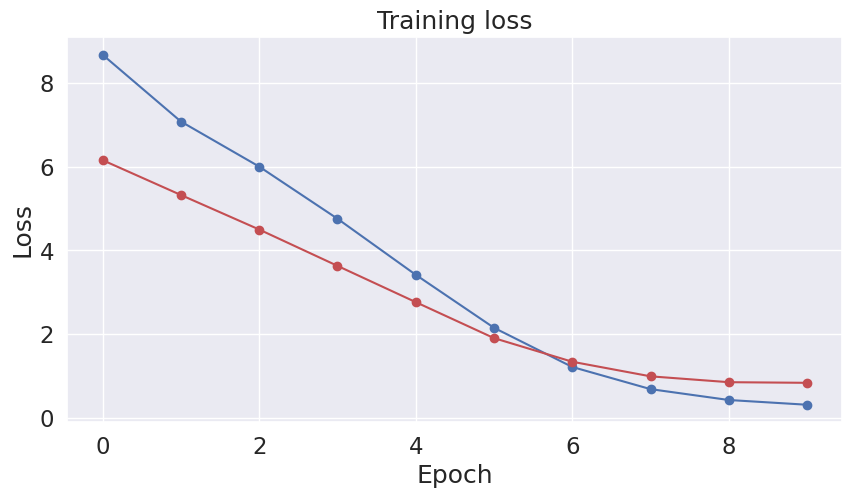

In [ ]:
#plot loss
import matplotlib.pyplot as plt

plt.plot(loss_values, 'b-o')
plt.plot(loss_values_val, 'r-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

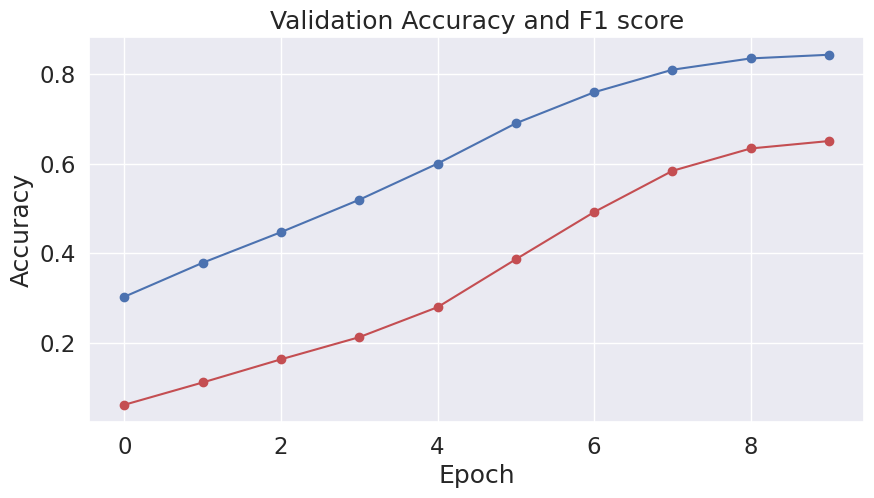

In [ ]:
#plot accuracy and f1 evolution
plt.plot(accuracy_values_val, 'b-o')
plt.plot(f1_score_values_val, 'r-o')
plt.title("Validation Accuracy and F1 score")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Réentrainement sur quelques epochs avec un batch size plus petit

In [ ]:

batch_size = 16
epochs = 4

train_dataloader_2 = DataLoader(
            dataset_train,  # The training samples.
            sampler = RandomSampler(dataset_train), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader_tr_2 = DataLoader(
            dataset_val_tr,
            batch_size = batch_size# Evaluate with this batch size.
        )


In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_values_val = []
accuracy_values_val = []
f1_score_values_val = []
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader_2):

        # Progress update every 40 batches.
        if step % 120 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}., loss {}'.format(step, len(train_dataloader_2), elapsed, total_loss / (step+1)))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        result = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = result.loss
        #check loss is not nan
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader_2)
    print("average training loss : ", avg_train_loss)


    avg_loss = get_evaluation_metrics(model, validation_dataloader_tr_2, word_ids_val, new_label_map, labels_validation)
    loss_values_val.append(avg_loss[0])
    accuracy_values_val.append(avg_loss[1])
    f1_score_values_val.append(avg_loss[2])


    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Validation loss: {0:.2f}".format(avg_loss[0]))
    print(" Validation Accuracy: {0:.2f}".format(avg_loss[1]))
    print(" Validation F1 score: {0:.2f}".format(avg_loss[2]))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   120  of  3,806.    Elapsed: 0:00:19., loss 0.2672050897087825
  Batch   240  of  3,806.    Elapsed: 0:00:38., loss 0.27939633762751825
  Batch   360  of  3,806.    Elapsed: 0:00:58., loss 0.2736718207781546
  Batch   480  of  3,806.    Elapsed: 0:01:22., loss 0.2749504868830351
  Batch   600  of  3,806.    Elapsed: 0:01:42., loss 0.27890974229465887
  Batch   720  of  3,806.    Elapsed: 0:02:01., loss 0.2734254319377401
  Batch   840  of  3,806.    Elapsed: 0:02:20., loss 0.27075868137261094
  Batch   960  of  3,806.    Elapsed: 0:02:39., loss 0.26599199805492546
  Batch 1,080  of  3,806.    Elapsed: 0:02:58., loss 0.2622246133482556
  Batch 1,200  of  3,806.    Elapsed: 0:03:17., loss 0.26207313492842216
  Batch 1,320  of  3,806.    Elapsed: 0:03:36., loss 0.26039976272312537
  Batch 1,440  of  3,806.    Elapsed: 0:03:55., loss 0.2576634378143697
  Batch 1,560  of  3,806.    Elapsed: 0:04:14., loss 0.25552862826129213
  Batch 1,680 

In [ ]:
#sauvegarde des modèles
torch.save(model, root+'my_model_custom_batch.pth')

torch.save(model.state_dict(), root+'my_model_custom_batch.pth')
tokenizer.save_pretrained(root+'my_tokenizer_custom_batch')
import json


with open(root+'labels.json', 'w') as f:
    json.dump(new_label_map, f)

### 7.3.3 Évaluation (2%)

Évaluez votre modèle sur le jeu de validation en utilisant la métrique «  Macro F1-Score Moyenne  »


Implémentez la fonction permettant de calculer la métrique Macro F1-Score Moyenne

In [ ]:
# Sauvegarder la cartographie des labels
avg_loss = get_evaluation_metrics(model, validation_dataloader_tr, word_ids_val, new_label_map, labels_validation)
print(" Validation loss: {0:.2f}".format(avg_loss[0]))
print(" Validation Accuracy: {0:.2f}".format(avg_loss[1]))
print(" Validation F1 score: {0:.2f}".format(avg_loss[2]))

 Validation loss: 0.63
 Validation Accuracy: 0.90
 Validation F1 score: 0.76


### 7.3.4 Soumission

Effectuez votre soumission pour Kaggle en respectant le format de soumission décrit précédemment.

Vous devez faire les prédictions sur le jeu de test et écrire les résultats dans un fichier submission.csv respectant le même format que _sample_submission.csv_. Vous devez utiliser le fichier _id_to_label.csv_ pour faire la correspondance.

In [ ]:

#evaluate on test set
tokens_test = preprocess_test(data_test)
input_ids_test, attention_masks_test, word_ids_test = tokenize_from_model(tokenizer, tokens_test)
pt_input_ids_test = torch.stack(input_ids_test, dim=0)
pt_attention_masks_test = torch.stack(attention_masks_test, dim=0)
dataset_test = TensorDataset(pt_input_ids_test, pt_attention_masks_test)
test_dataloader = DataLoader(
            dataset_test,
            batch_size = batch_size
        )
model.eval()
predict_labels = []
with torch.no_grad() :
    for step, batch in enumerate(test_dataloader) :
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        result = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
        logits_BIO,logits_prefix,logits_label = result.logits
        logits_BIO = logits_BIO.detach().cpu().numpy()
        logits_prefix = logits_prefix.detach().cpu().numpy()
        logits_label = logits_label.detach().cpu().numpy()

        labels_BIO = np.argmax(logits_BIO, axis=2)
        labels_prefix = np.argmax(logits_prefix, axis=2)
        labels_label = np.argmax(logits_label, axis=2)
        predict_labels.append(np.stack([labels_BIO, labels_prefix, labels_label], axis=-1))

predict_labels = np.concatenate(predict_labels)
formated_predict_labels = get_label_list_from_predict(predict_labels, word_ids_test, new_label_map)
data_test['question_tagged'] = formated_predict_labels
data_test.head()

In [120]:
labeled_test = pd.DataFrame(columns=["Id","Target"])

tot_id = 1
ids_to_label = pd.read_csv(root+'id_to_label.csv', sep=',')
for question_id,row in data_test.iterrows() :
    question_id+=1
    to_tabel = ids_to_label[ids_to_label['question_id'] == question_id]
    nb_to_classifie = len(to_tabel)
    all_tags = []
    for tag in row['question_tagged'] :
        if tag.startswith('B-') :
            all_tags.append(tag[2:])
    if len(all_tags) <= nb_to_classifie :
        all_tags += ['']*(nb_to_classifie-len(all_tags))
        for tag in all_tags :
            labeled_test = pd.concat([labeled_test, pd.DataFrame([[tot_id,tag]], columns=["Id","Target"])])
            tot_id += 1
    else :
        for tag in range(nb_to_classifie):
            labeled_test = pd.concat([labeled_test, pd.DataFrame([[tot_id,all_tags[tag]]], columns=["Id","Target"])])
            tot_id += 1
labeled_test.head()
labeled_test.to_csv(root+'test_labels.csv', index=False)




### 7.4. Conclusion (5%)


*L'architecture proposée à le mérite d'etre plutot innovante en decoupant de probleme de classification en 3, de plus l'ajout de données et l'augmentation de celles ci est surement très efficace notamment au vu de la faible fréquence de nombreux jetons. De plus la décomposition en plusieurs classification permet de diviser le problème en 3 sous problemes et donc simplifie l'apprentissage en donnant un "sens" aux classes combinées*

*Néanmoins il subsiste toujours le probleme des jetons non présents dans le dataset d'entrainement/validation. Ce probleme pourrait etre resolu pour les classes qui ne sont pas des propriétés ou des ressources wikidata par exemple par un modèle génératif mais pour les classes wikidata elles meme cela semble difficile à la vue du nombre astronomique de classes. Il faudrait sinon génerer un moyen de query une base de données entiere mais la prédiction directe de toutes les classes semble compliqué.*

*Enfin dans le cadre de ce challenge on pourrait si l'on voulait utiliser l'api de wikidata pour essayer de recuperer les identifiants des id_to_label et de l'ajouter à l'ensemble d'entrainement \( à condition que ce ne soit pas considéré comme de la triche \)*